In [ ]:
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)

Data Load

In [2]:
# 전처리 때 저장해둔 파일 불러오기
X_train = pickle.load(open("../data/X_train.pkl", "rb"))
y_train = pickle.load(open("../data/y_train.pkl", "rb"))
X_test  = pickle.load(open("../data/X_test.pkl", "rb"))

print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)
print("y_train distribution:")
print(y_train.value_counts())

X_train shape: (891, 15)
X_test shape : (418, 15)
y_train distribution:
Survived
0    549
1    342
Name: count, dtype: int64


Data Split

In [3]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train  # 클래스 비율 유지
)

print("Train:", X_tr.shape, "Valid:", X_val.shape)

Train: (712, 15) Valid: (179, 15)


### LogisticRegression

In [4]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 3, 10],   # 정규화 강도
    'class_weight': ['balanced', None],  # 비교하도록
    'solver': ['lbfgs', 'liblinear'],    
    'penalty': ['l2']                    # 규제 방식
}

log_reg = LogisticRegression(max_iter=1000)

grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best Params:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/opt/anaconda3/envs/titanic/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/titanic/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/p

Best Params: {'C': 1, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV Score: 0.8282781997363632


/opt/anaconda3/envs/titanic/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/titanic/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/p

In [5]:
best_params = grid_search.best_params_
print("Best Params:", best_params)


best_log_reg = LogisticRegression(
    max_iter=1000,
    C=best_params['C'],
    penalty=best_params['penalty'],
    solver=best_params['solver'],
    class_weight=best_params['class_weight']
)

best_log_reg.fit(X_tr, y_tr)

val_pred = best_log_reg.predict(X_val)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Validation Accuracy:", accuracy_score(y_val, val_pred))

print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_val, val_pred))

print("\n=== Classification Report ===")
print(classification_report(y_val, val_pred, digits=4))

Best Params: {'C': 1, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
Validation Accuracy: 0.8491620111731844

=== Confusion Matrix ===
[[99 11]
 [16 53]]

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.8609    0.9000    0.8800       110
           1     0.8281    0.7681    0.7970        69

    accuracy                         0.8492       179
   macro avg     0.8445    0.8341    0.8385       179
weighted avg     0.8482    0.8492    0.8480       179



### Random forest

랜덤포레스트 + 그리드 설정

In [6]:
rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
) 

param_grid_rf = {
    'n_estimators': [200, 300, 500],   # 트리 개수
    'max_depth': [None, 5, 10, 20],    # 트리 최대 깊이
    'min_samples_split': [2, 5],       # 노드 분할 최소 샘플 수
    'min_samples_leaf': [1, 2, 4]      # 리프 노드 최소 샘플 수
}

rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

Best parameter 찾기

In [7]:
rf_grid.fit(X_train, y_train)

print("Best Params (RF):", rf_grid.best_params_)
print("Best CV Score (RF):", rf_grid.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Params (RF): {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
Best CV Score (RF): 0.8294017952419811


best_params로 train/val 기준 성능 평가

In [8]:
best_params_rf = rf_grid.best_params_

best_rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    **best_params_rf
)

# X_tr / y_tr 로 학습
best_rf.fit(X_tr, y_tr)

# 검증셋 성능
rf_val_pred = best_rf.predict(X_val)
rf_val_acc = accuracy_score(y_val, rf_val_pred)

print(f"Validation Accuracy (RandomForest, best): {rf_val_acc:.4f}")

print("\n=== Confusion Matrix (RF) ===")
print(confusion_matrix(y_val, rf_val_pred))

print("\n=== Classification Report (RF) ===")
print(classification_report(y_val, rf_val_pred, digits=4))

Validation Accuracy (RandomForest, best): 0.8156

=== Confusion Matrix (RF) ===
[[98 12]
 [21 48]]

=== Classification Report (RF) ===
              precision    recall  f1-score   support

           0     0.8235    0.8909    0.8559       110
           1     0.8000    0.6957    0.7442        69

    accuracy                         0.8156       179
   macro avg     0.8118    0.7933    0.8000       179
weighted avg     0.8145    0.8156    0.8128       179



Feature Importance 확인

In [9]:
importances = best_rf.feature_importances_
feature_names = X_train.columns

imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

imp_df.head(15)

,feature,importance
10,Title_Mr,0.173623
2,Fare,0.166049
5,Sex_male,0.136800
1,Age,0.107480
0,PassengerId,0.106437
7,Pclass_3,0.069643
3,FamilySize,0.063696
9,Title_Miss,0.049561
11,Title_Mrs,0.046893
14,Embarked_S,0.021837


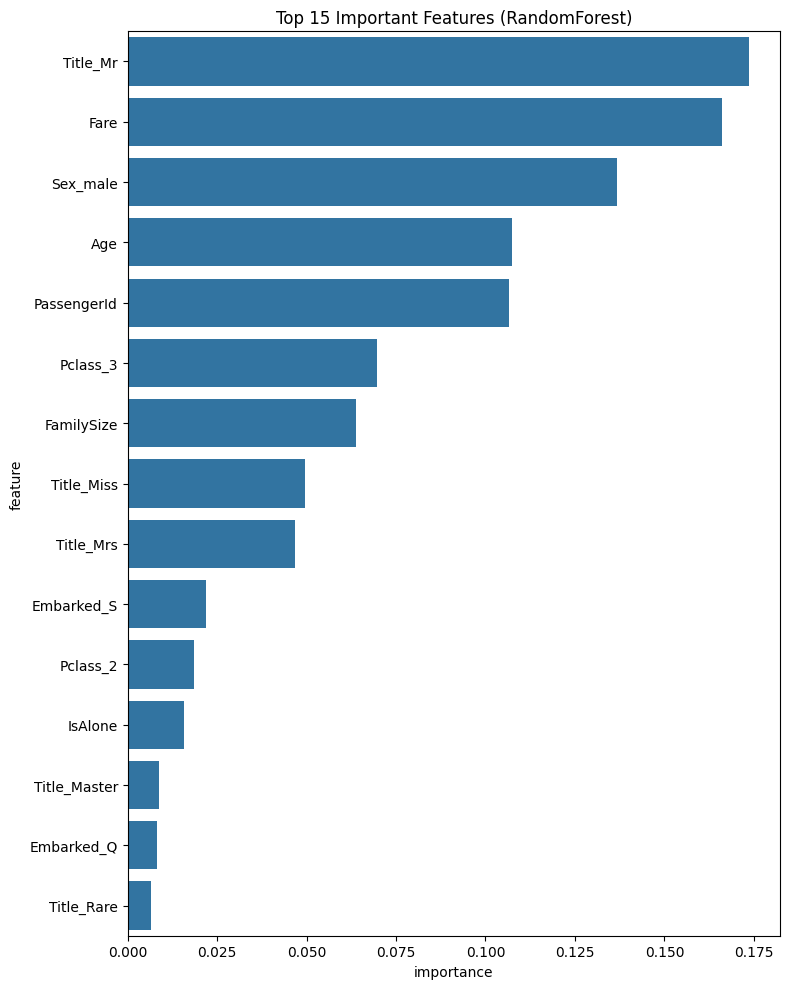

In [10]:
plt.figure(figsize=(8, 10))
sns.barplot(data=imp_df.head(15), x="importance", y="feature")
plt.title("Top 15 Important Features (RandomForest)")
plt.tight_layout()
plt.show()

### XGBoost

In [11]:
# 1) 기본 XGBoost 모델 (틀만 생성)
xgb = XGBClassifier(
    objective="binary:logistic",
    random_state=42,
    n_jobs=-1,
    tree_method="hist",   # 없으면 지워도 됨 (속도용)
)

# 2) 탐색할 하이퍼파라미터 범위
param_grid_xgb = {
    "n_estimators": [300, 400],          # 트리 개수
    "max_depth": [3, 4],                 # 트리 깊이 (너무 깊게 안 감)
    "learning_rate": [0.03, 0.05, 0.1],  # 학습률
    "subsample": [0.8, 1.0],             # row 샘플링 비율
    "colsample_bytree": [0.8, 1.0],      # feature 샘플링 비율
    "min_child_weight": [1, 3],          # 리프 노드 최소 가중치
    "gamma": [0, 0.1]                    # 분할 최소 손실 감소
}


# 3) GridSearchCV 설정
xgb_grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=1,
)

# 4) 전체 X_train, y_train으로 튜닝
xgb_grid.fit(X_train, y_train)

print("Best Params (XGB):", xgb_grid.best_params_)
print("Best CV Score (XGB):", xgb_grid.best_score_)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Params (XGB): {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.03, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}
Best CV Score (XGB): 0.8328290753876091


best_params로 성능 평가

In [12]:
best_params_xgb = xgb_grid.best_params_

best_xgb = XGBClassifier(
    objective="binary:logistic",
    random_state=42,
    n_jobs=-1,
    **best_params_xgb
)

# 미리 나눠둔 X_tr, y_tr 로 학습
best_xgb.fit(X_tr, y_tr)

# 검증셋에서 성능 평가
xgb_val_pred = best_xgb.predict(X_val)
xgb_val_acc = accuracy_score(y_val, xgb_val_pred)

print(f"Validation Accuracy (XGBoost): {xgb_val_acc:.4f}")

print("\n=== Confusion Matrix (XGB) ===")
print(confusion_matrix(y_val, xgb_val_pred))

print("\n=== Classification Report (XGB) ===")
print(classification_report(y_val, xgb_val_pred, digits=4))

Validation Accuracy (XGBoost): 0.8268

=== Confusion Matrix (XGB) ===
[[99 11]
 [20 49]]

=== Classification Report (XGB) ===
              precision    recall  f1-score   support

           0     0.8319    0.9000    0.8646       110
           1     0.8167    0.7101    0.7597        69

    accuracy                         0.8268       179
   macro avg     0.8243    0.8051    0.8122       179
weighted avg     0.8260    0.8268    0.8242       179



### Ensemble

실험 1) Hard Voting

In [13]:
# 1) Hard Voting 앙상블 (LogReg + XGB)
hard_voting_clf = VotingClassifier(
    estimators=[
        ("logreg", best_log_reg),
        ("xgb", best_xgb),
    ],
    voting="hard" 
)

# 2) train/val 기준으로 학습
hard_voting_clf.fit(X_tr, y_tr)

# 3) 검증셋 평가
hard_pred = hard_voting_clf.predict(X_val)
hard_acc = accuracy_score(y_val, hard_pred)

print(f"Validation Accuracy (Hard Voting): {hard_acc:.4f}")

print("\n=== Confusion Matrix (Hard Voting) ===")
print(confusion_matrix(y_val, hard_pred))

print("\n=== Classification Report (Hard Voting) ===")
print(classification_report(y_val, hard_pred, digits=4))

Validation Accuracy (Hard Voting): 0.8268

=== Confusion Matrix (Hard Voting) ===
[[103   7]
 [ 24  45]]

=== Classification Report (Hard Voting) ===
              precision    recall  f1-score   support

           0     0.8110    0.9364    0.8692       110
           1     0.8654    0.6522    0.7438        69

    accuracy                         0.8268       179
   macro avg     0.8382    0.7943    0.8065       179
weighted avg     0.8320    0.8268    0.8209       179



실험 2) Soft Voting

In [14]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from itertools import product
import pandas as pd

weight_candidates = [(a, b) for a, b in product(range(1, 6), repeat=2)]  # (1~5, 1~5)

results = []

for w in weight_candidates:
    voting_clf = VotingClassifier(
        estimators=[
            ("logreg", best_log_reg),
            ("xgb", best_xgb),
        ],
        voting="soft",
        weights=list(w)
    )

    voting_clf.fit(X_tr, y_tr)
    pred = voting_clf.predict(X_val)
    acc = accuracy_score(y_val, pred)

    results.append({
        "weight_logreg": w[0],
        "weight_xgb": w[1],
        "val_acc": acc
    })

# 결과를 표로 정리해서 상위 몇 개만 보기
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("val_acc", ascending=False)

print(results_df.head(10))

    weight_logreg  weight_xgb   val_acc
8               2           4  0.860335
14              3           5  0.860335
1               1           2  0.860335
13              3           4  0.854749
7               2           3  0.854749
19              4           5  0.849162
9               2           5  0.849162
2               1           3  0.843575
20              5           1  0.843575
0               1           1  0.837989


In [15]:
# 테스트할 weight 조합
weight_candidates = [(a, b) for a, b in product(range(1, 6), repeat=2)]  # (1~5, 1~5)


best_weight = None
best_acc = 0
results = []

for w in weight_candidates:
    print("="*60)
    print(f"Testing weights = {w}")

    voting_clf = VotingClassifier(
        estimators=[
            ("logreg", best_log_reg),
            ("xgb", best_xgb),
        ],
        voting="soft",
        weights=w
    )

    # 학습
    voting_clf.fit(X_tr, y_tr)

    # 검증셋 평가
    voting_val_pred = voting_clf.predict(X_val)
    voting_val_acc = accuracy_score(y_val, voting_val_pred)

    print(f"Validation Accuracy (Voting, weights={w}): {voting_val_acc:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_val, voting_val_pred))
    print("\nClassification Report:")
    print(classification_report(y_val, voting_val_pred, digits=4))

    # 가장 좋은 weight 저장
    if voting_val_acc > best_acc:
        best_acc = voting_val_acc
        best_weight = w

    # 기록 저장
    results.append((w, voting_val_acc))

print("="*60)
print(f"Best Weight: {best_weight}  → Accuracy: {best_acc:.4f}")

Testing weights = (1, 1)
Validation Accuracy (Voting, weights=(1, 1)): 0.8380

Confusion Matrix:
[[98 12]
 [17 52]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8522    0.8909    0.8711       110
           1     0.8125    0.7536    0.7820        69

    accuracy                         0.8380       179
   macro avg     0.8323    0.8223    0.8265       179
weighted avg     0.8369    0.8380    0.8367       179

Testing weights = (1, 2)
Validation Accuracy (Voting, weights=(1, 2)): 0.8603

Confusion Matrix:
[[101   9]
 [ 16  53]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8632    0.9182    0.8899       110
           1     0.8548    0.7681    0.8092        69

    accuracy                         0.8603       179
   macro avg     0.8590    0.8431    0.8495       179
weighted avg     0.8600    0.8603    0.8588       179

Testing weights = (1, 3)
Validation Accuracy (Voting, weights=

최고 성능 모델로 시각화

In [16]:
# 검증용 앙상블 (X_tr, y_tr 기준)
val_voting_clf = VotingClassifier(
    estimators=[
        ("logreg", best_log_reg),
        ("xgb", best_xgb),
    ],
    voting="soft",
    weights=[1, 2]
)

val_voting_clf.fit(X_tr, y_tr)

,estimators,"[('logreg', ...), ('xgb', ...)]"
,voting,'soft'
,weights,"[1, 2]"
,n_jobs,None
,flatten_transform,True
,verbose,False
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1
,fit_intercept,True


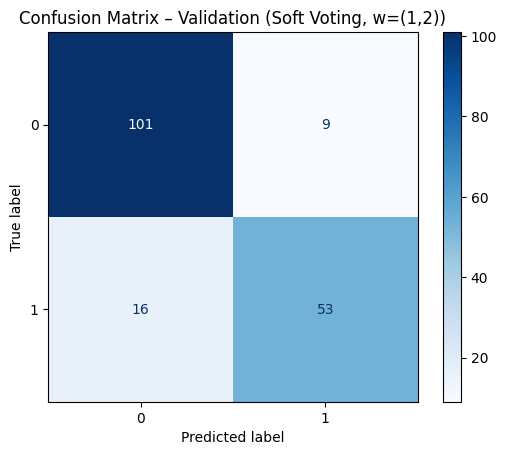

In [17]:
ConfusionMatrixDisplay.from_estimator(val_voting_clf, X_val, y_val, cmap="Blues")
plt.title("Confusion Matrix – Validation (Soft Voting, w=(1,2))")
plt.show()

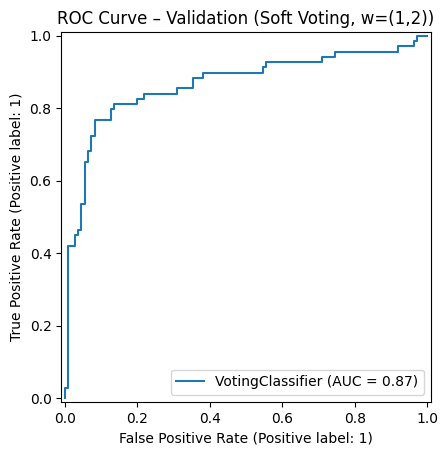

In [18]:
RocCurveDisplay.from_estimator(val_voting_clf, X_val, y_val)
plt.title("ROC Curve – Validation (Soft Voting, w=(1,2))")
plt.show()

최종 파이널 모델로 Kaggle Test Data 예측

In [19]:
final_model = VotingClassifier(
    estimators=[
        ("logreg", best_log_reg),
        ("xgb", best_xgb),
    ],
    voting="soft",
    weights=[1, 2]
)

final_model.fit(X_train, y_train)

# 2) test 예측
test_pred = final_model.predict(X_test)

# 3) PassengerId 가져오기
test_passenger_ids = X_test["PassengerId"]

# 4) 제출 파일 생성
submission = pd.DataFrame({
    "PassengerId": test_passenger_ids,
    "Survived": test_pred.astype(int)
})

print(submission.head())
print(submission.shape) 

   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1
(418, 2)


In [21]:
submission.to_csv("../submission/submission_final.csv", index=False)

print("Saved: submission_final.csv")
print(submission.head())
print(submission.shape)   # (418, 2)

Saved: submission_final.csv
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1
(418, 2)
